In [1]:
import sys
import io

In [2]:
from ortools.constraint_solver import pywrapcp

In [3]:
from coptpy import *
import numpy as np
import matplotlib.pyplot as plt
import igraph
import networkx as nx
import matplotlib.pyplot as plt
import math
from networkx.drawing.nx_pydot import graphviz_layout


In [4]:
class CaptureStdout:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = self._stringio = io.StringIO()
        return self

    def __exit__(self, *args):
        sys.stdout = self._original_stdout

    def get_output(self):
        return self._stringio.getvalue()

In [5]:
rnd = np.random
rnd.seed(0)

In [6]:
env = Envr()
model = env.createModel()

Cardinal Optimizer v6.0.5. Build date Feb  7 2023
Copyright Cardinal Operations 2022. All Rights Reserved



In [7]:
edges = [(0,1,5),(0,2,7),(1,3,2),(2,4,3)]

In [8]:
graph = nx.Graph()
graph.add_weighted_edges_from(edges)
print(graph.edges())

[(0, 1), (0, 2), (1, 3), (2, 4)]


In [9]:
graph.edges[0,2]["weight"]

7

In [10]:
p = dict(nx.shortest_path_length(graph,target = 0 , weight='weight'))

In [11]:
def create_random_tree(num_nodes, min_children=1, max_children=5, seed=0):
    rnd = np.random.RandomState(seed)
    tree = nx.Graph()
    tree.add_node(0)

    current_node = 0
    node_counter = 1

    nodes_to_expand = [0]

    while nodes_to_expand and node_counter < num_nodes:
        node = nodes_to_expand.pop(0)
        num_children = rnd.randint(min_children, max_children + 1)
        
        for _ in range(num_children):
            if node_counter >= num_nodes:
                break

            tree.add_edge(node, node_counter)
            nodes_to_expand.append(node_counter)
            node_counter += 1

    return tree

In [12]:
n = 40 #Count of nodes

#xc yc
xc = rnd.rand(n+1)*200
yc = rnd.rand(n+1)*100

#Initialize 
graph = create_random_tree(n+1)

for i,j in graph.edges():
    graph.edges[i,j]["weight"] =  math.ceil(np.hypot(xc[i] - xc[j],yc[i] - yc[j]))



In [13]:
#Input Parameters
C = 100
N = [i for i in range(1,n+1)]

D = {i: rnd.randint(20,81) for i in N}#Demand at node i

L = dict(nx.shortest_path_length(graph, weight='weight'))
S = dict(nx.shortest_path_length(graph,target = 0 , weight='weight'))

sum_dem = 0
for i in D:
    sum_dem +=D[i]
V_min = math.ceil(sum_dem/C)+6


    

#Initialize weight

print(V_min)

26


In [14]:
x = model.addVars(N, N, vtype=COPT.BINARY)
y = model.addVars(N, N, vtype=COPT.BINARY)
w = model.addVars(N, vtype=COPT.BINARY)
z = model.addVars(N, vtype=COPT.BINARY)

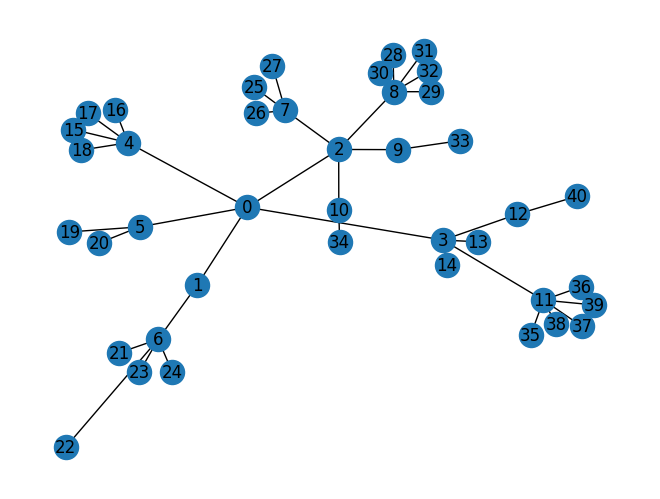

In [15]:
nx.draw(graph,with_labels=True)
plt.show()

In [16]:
#ObjFunc
model.setObjective(quicksum(S[i] * (w[i] + z[i]) for i in N) +
                   quicksum(quicksum(L[i][j] * x[i, j] for j in range(i+1,n+1)) for i in range(1,n)), COPT.MINIMIZE)

In [17]:

# Constraints
for i in N:
    for j in N:
        if i < j:
            model.addConstr(x[i, j] - y[i, j] <= 0)
            for k in N:
                if i < j < k:
                    model.addConstr(y[i, j] + y[j, k] - y[i, k] <= 1)
for j in N:
    model.addConstr((w[j] + quicksum(x[i,j] for i in range(1,j))) == 1)
for i in N:
    model.addConstr((z[i] + quicksum(x[i,j] for j in range(i+1,n+1)))==1)
    model.addConstr((D[i] + quicksum(D[j]*y[i,j] for j in range(i+1,n+1))) <= C)

#Valid Inequalities    
for i in N:
    for j in N:
        if i<j and (D[i] + D[j] > C ):
            model.addConstr(y[i,j] == 0)
            
#for k in N:
#    model.addConstr(quicksum(w[j]+quicksum(x[i,j] for i in range(1,k)) for j in range(k,n+1)) >= V_kmin[k])

In [18]:
model.setParam(COPT.Param.TimeLimit, 600.0)

Setting parameter 'TimeLimit' to 600


In [19]:
model.solve()

Model fingerprint: b02ae8f0

Using Cardinal Optimizer v6.0.5 on Windows
Hardware has 6 cores and 12 threads. Using instruction set X86_NATIVE (1)
Minimizing a MIP problem

The original problem has:
    11158 rows, 3280 columns and 33998 non-zero elements
    3280 binaries

Presolving the problem

The presolved problem has:
    119 rows, 73 columns and 437 non-zero elements
    73 binaries

Starting the MIP solver with 12 threads and 32 tasks

     Nodes    Active  LPit/n  IntInf     BestBound  BestSolution    Gap   Time
         0         1      --       0  5.264000e+03            --    Inf  0.10s
H        0         1      --       0  5.264000e+03  1.006000e+04  47.7%  0.10s
H        0         1      --       0  5.264000e+03  9.980000e+03  47.3%  0.10s
H        0         1      --       0  5.264000e+03  9.404000e+03  44.0%  0.10s
         0         1      --      10  9.264000e+03  9.404000e+03  1.49%  0.11s
H        0         1      --      10  9.264000e+03  9.376000e+03  1.19%  0.12s


In [20]:
def get_vehicle_routes(w, x, z):
    routes = []
    for i in N:
        if w[i].x > 0.5:  # Node i is the first node visited by a vehicle
            route = [i]
            current_node = i
            while not z[current_node].x > 0.5:  # Continue until the last node is found
                for j in N:
                    if x[current_node, j].x > 0.5:
                        route.append(j)
                        current_node = j
                        break
            routes.append(route)
    return routes

def print_vehicle_routes(routes):
    vehicle_num = 1
    for route in routes:
        print(f"Vehicle {vehicle_num} route: {route}")
        vehicle_num += 1



# Get and print vehicle routes
routes = get_vehicle_routes(w, x, z)
print_vehicle_routes(routes)

Vehicle 1 route: [1]
Vehicle 2 route: [2, 30]
Vehicle 3 route: [3, 40]
Vehicle 4 route: [4]
Vehicle 5 route: [5, 20]
Vehicle 6 route: [6, 23]
Vehicle 7 route: [7, 26]
Vehicle 8 route: [8]
Vehicle 9 route: [9]
Vehicle 10 route: [10, 34]
Vehicle 11 route: [11, 37]
Vehicle 12 route: [12]
Vehicle 13 route: [13, 14]
Vehicle 14 route: [15, 16]
Vehicle 15 route: [17]
Vehicle 16 route: [18]
Vehicle 17 route: [19]
Vehicle 18 route: [21]
Vehicle 19 route: [22]
Vehicle 20 route: [24]
Vehicle 21 route: [25, 27]
Vehicle 22 route: [28]
Vehicle 23 route: [29]
Vehicle 24 route: [31]
Vehicle 25 route: [32]
Vehicle 26 route: [33]
Vehicle 27 route: [35, 36]
Vehicle 28 route: [38, 39]


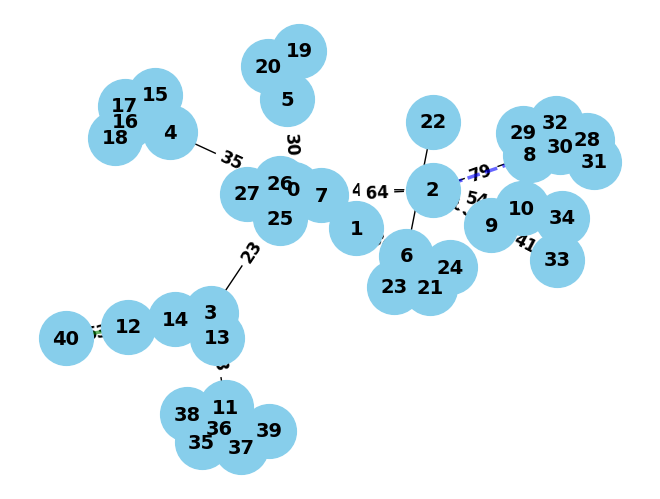

In [21]:

def visualize_vehicle_routes(G, pos, routes):
    # Draw the nodes and labels
    nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=1500, font_size=14, font_weight="bold")
    
    # Draw edge labels with weights
    edge_labels = {(u, v): d["weight"] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_weight="bold")
    
    # Prepare a list of colors for the routes
    colors = ["red", "blue", "green", "purple", "orange", "brown", "cyan", "magenta", "lime", "gray"]

    # Draw vehicle routes
    for index, route in enumerate(routes):
        color = colors[index % len(colors)]  # Choose a color for the route
        edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=2.5, edge_color=color, style="dashed", alpha=0.6)

    plt.show()


# Get vehicle routes and visualize them
routes = get_vehicle_routes(w, x, z)
pos = nx.spring_layout(graph)
visualize_vehicle_routes(graph, pos, routes)

In [22]:
#OR-Tools realization

In [23]:
#distance_matix
distance_matrix = []
for i in range(n+1):
    a = []
    for j in range(n+1):
        if(i == j):
            a.append(0)
        else:
            a.append(10000)
    distance_matrix.append(a)


for i in range(n+1):
    for j in range(n+1):
        if (i, j) in graph.edges():
            distance_matrix[i][j] = graph.edges[i,j]["weight"]
            distance_matrix[j][i] = graph.edges[i,j]["weight"]


In [24]:
#demands
demands = [0] + [D[i] for i in D]

#Vehicle_capacities
v_capacities = [C for i in range(1,V_min+1)]

distance_M = []
for i in range(0,n+1):
    a = []
    for j in range(0,n+1):
        a.append(L[i][j])
    distance_M.append(a)
print(demands)
print(D)
print(v_capacities)

[0, 79, 23, 38, 66, 55, 40, 37, 70, 47, 34, 61, 78, 21, 56, 30, 42, 63, 60, 31, 22, 71, 36, 52, 74, 20, 58, 39, 66, 62, 71, 76, 80, 60, 33, 50, 44, 22, 23, 50, 54]
{1: 79, 2: 23, 3: 38, 4: 66, 5: 55, 6: 40, 7: 37, 8: 70, 9: 47, 10: 34, 11: 61, 12: 78, 13: 21, 14: 56, 15: 30, 16: 42, 17: 63, 18: 60, 19: 31, 20: 22, 21: 71, 22: 36, 23: 52, 24: 74, 25: 20, 26: 58, 27: 39, 28: 66, 29: 62, 30: 71, 31: 76, 32: 80, 33: 60, 34: 33, 35: 50, 36: 44, 37: 22, 38: 23, 39: 50, 40: 54}
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [25]:

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] =  distance_M
    data['demands'] = demands
    data['vehicle_capacities'] = v_capacities
    data['num_vehicles'] = V_min
    data['depot'] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))


def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(1)
    

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
        
        
    
    


if __name__ == '__main__':
    main()
  



Objective: 9424
Route for vehicle 0:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 1:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 2:
 0 Load(0) ->  30 Load(71) ->  0 Load(71)
Distance of the route: 520m
Load of the route: 71

Route for vehicle 3:
 0 Load(0) ->  27 Load(39) ->  26 Load(97) ->  0 Load(97)
Distance of the route: 620m
Load of the route: 97

Route for vehicle 4:
 0 Load(0) ->  29 Load(62) ->  0 Load(62)
Distance of the route: 490m
Load of the route: 62

Route for vehicle 5:
 0 Load(0) ->  32 Load(80) ->  0 Load(80)
Distance of the route: 448m
Load of the route: 80

Route for vehicle 6:
 0 Load(0) ->  21 Load(71) ->  0 Load(71)
Distance of the route: 426m
Load of the route: 71

Route for vehicle 7:
 0 Load(0) ->  28 Load(66) ->  0 Load(66)
Distance of the route: 424m
Load of the route: 66

Route for vehicle 8:
 0 Load(0) ->  22 Load(36) ->  23 Load(88) ->  0 Load(88)
Distance of the r

# 